In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import matplotlib.image as pltimg
import graphviz 

############################
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor,VotingClassifier,RandomForestClassifier
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_predict, KFold, train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error,r2_score
from sklearn.tree._export import plot_tree

C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
df_Nacional = pd.read_csv('../microdadosEnem_Nacional_Amostragem.csv', sep = ';', encoding='ISO 8859-1')
df_Nacional = df_Nacional.loc[:, ~df_Nacional.columns.str.contains('^Unnamed')]
df_Nacional

,NU_INSCRICAO,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,NU_NOTA_CN,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
0,180008411121,AL,19.0,1.0,0.0,3.0,1.0,1.0,0.0,442.4,...,A,B,B,A,B,A,B,B,A,A
1,180008788016,AL,40.0,0.0,2.0,3.0,6.0,1.0,0.0,393.8,...,A,B,B,A,B,A,A,B,A,A
2,180008411503,AL,24.0,1.0,0.0,3.0,7.0,1.0,0.0,449.5,...,B,B,B,A,B,A,A,B,A,C
3,180008257102,AL,28.0,0.0,0.0,3.0,8.0,1.0,0.0,478.5,...,A,B,A,A,D,A,A,B,A,A
4,180008309661,AL,17.0,1.0,0.0,3.0,0.0,1.0,0.0,594.7,...,A,C,B,A,C,A,A,A,B,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64600,180013469026,AL,34.0,1.0,0.0,3.0,0.0,1.0,0.0,410.0,...,A,B,A,B,B,B,B,A,A,A
64601,180013985741,AL,20.0,0.0,0.0,3.0,2.0,1.0,0.0,413.0,...,A,B,A,A,B,A,A,B,A,A
64602,180013955750,AL,18.0,1.0,0.0,3.0,0.0,2.0,0.0,491.1,...,A,A,A,A,B,A,A,A,B,A
64603,180013983882,AL,18.0,1.0,0.0,2.0,0.0,1.0,0.0,471.0,...,A,B,B,A,C,A,B,B,B,B


In [5]:
# feature-cols vai armazenar todas as colunas exceto a coluna que armazena as
# notas de matemática do participante de Alagoas
feature_cols = [x for x in df_Nacional.columns if x != 'NU_NOTA_MT']
X = df_Nacional[feature_cols]
Y = df_Nacional['NU_NOTA_MT']

In [6]:
# Leitura dos datasets de treino e teste e criação do df de resposta
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.3, random_state=0)
#test-size = 0.3 define que o tamanho da base de teste é de 30% da base principal, e a base de treino é 70%

#visualizando os tamanhos da bases, teino e teste
print(X.shape, Y.shape, X_train.shape, y_train.shape ,X_test.shape, y_test.shape)

(64605, 40) (64605,) (45223, 40) (45223,) (19382, 40) (19382,)


In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = ['NU_IDADE', 'TP_SEXO','TP_ESTADO_CIVIL', 'TP_COR_RACA','TP_ANO_CONCLUIU', 'TP_ESCOLA',
                    'IN_TREINEIRO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO',  'Q005']

numeric_transformer = Pipeline(   steps=[ ('scaler', StandardScaler())])

categorical_features = ['Q001', 'Q002', 'Q003', 'Q004','Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011','Q012', 'Q013', 'Q014',
                        'Q015','Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

X_train = X_train[numeric_features + categorical_features]
X_test = X_test[numeric_features + categorical_features]

preprocessing = ColumnTransformer(transformers=[
                                        ('num', numeric_transformer, numeric_features),                                       
                                        ('cat', categorical_transformer, categorical_features),  
])

In [8]:
rf = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42 ))
])
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['NU_IDADE', 'TP_SEXO',
                                                   'TP_ESTADO_CIVIL',
                                               

In [9]:
lr =  Pipeline([
    ('preprocess', preprocessing),
    ('regressor', LinearRegression())
])
lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['NU_IDADE', 'TP_SEXO',
                                                   'TP_ESTADO_CIVIL',
                                               

In [9]:
rn = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', MLPRegressor(hidden_layer_sizes=(50, 50),tol=1e-2,max_iter=500, random_state=0))
])
rn.fit(X_train, y_train)

C:\Users\aleon\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['NU_IDADE', 'TP_SEXO',
                                                   'TP_ESTADO_CIVIL',
                                               

In [11]:
dtree = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', DecisionTreeRegressor(random_state=0))
])
dtree.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['NU_IDADE', 'TP_SEXO',
                                                   'TP_ESTADO_CIVIL',
                                               

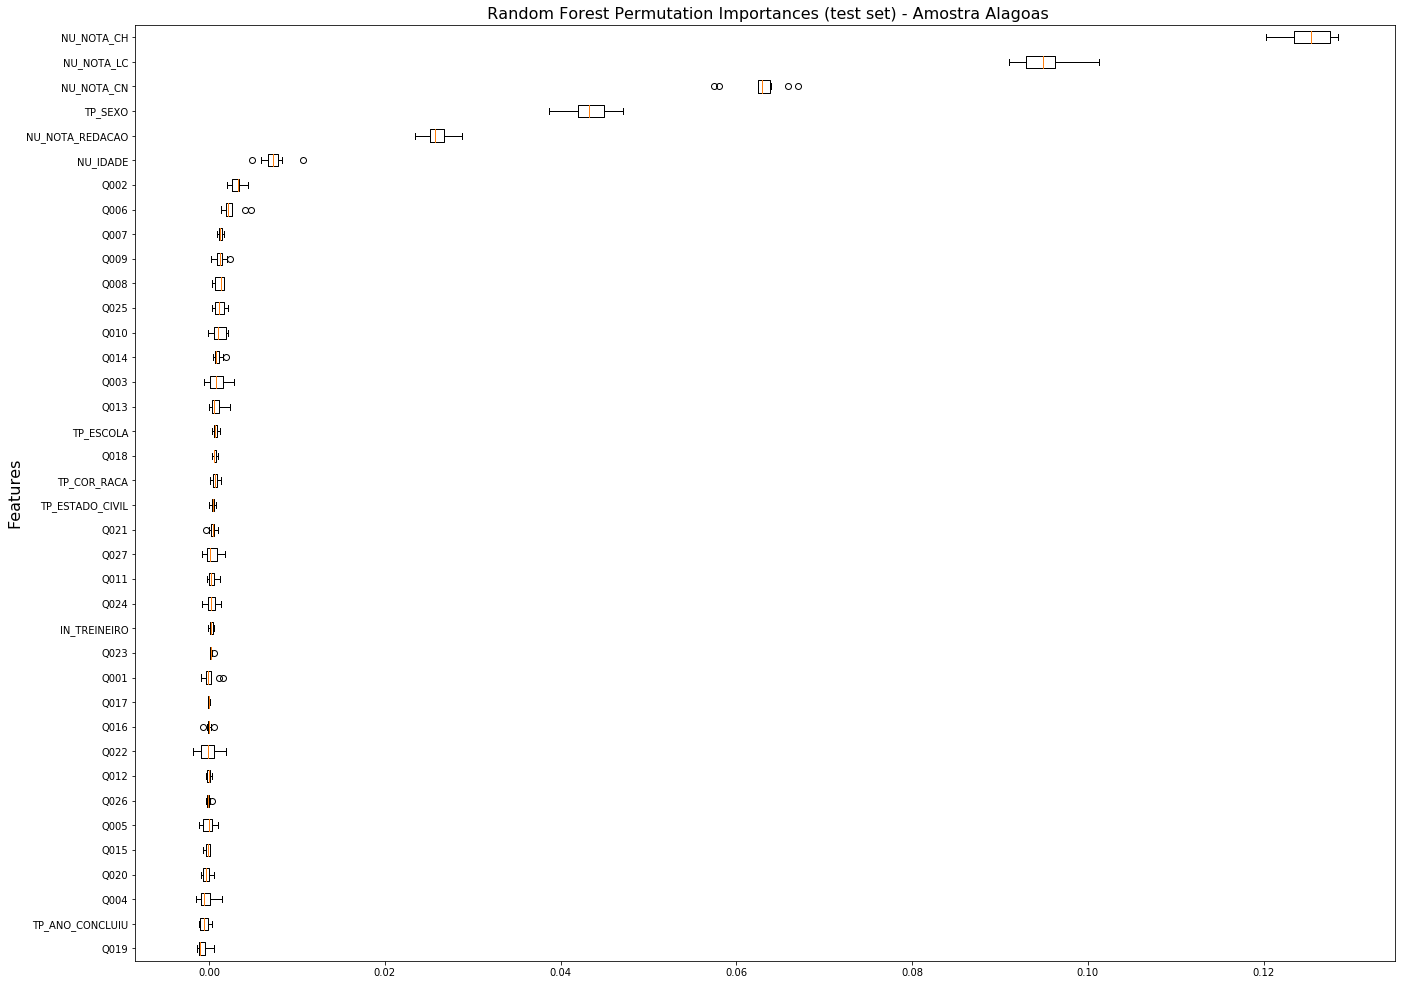

In [14]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title(" Random Forest Permutation Importances (test set) - Amostra Alagoas", fontsize=16)
ax.set_ylabel("Features", fontsize = 16)
fig.tight_layout(pad=1.08, h_pad=5, w_pad=5, rect=None)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.savefig('imagens/permutationImportances_RF_MT_AL.png', format='png')

plt.show()

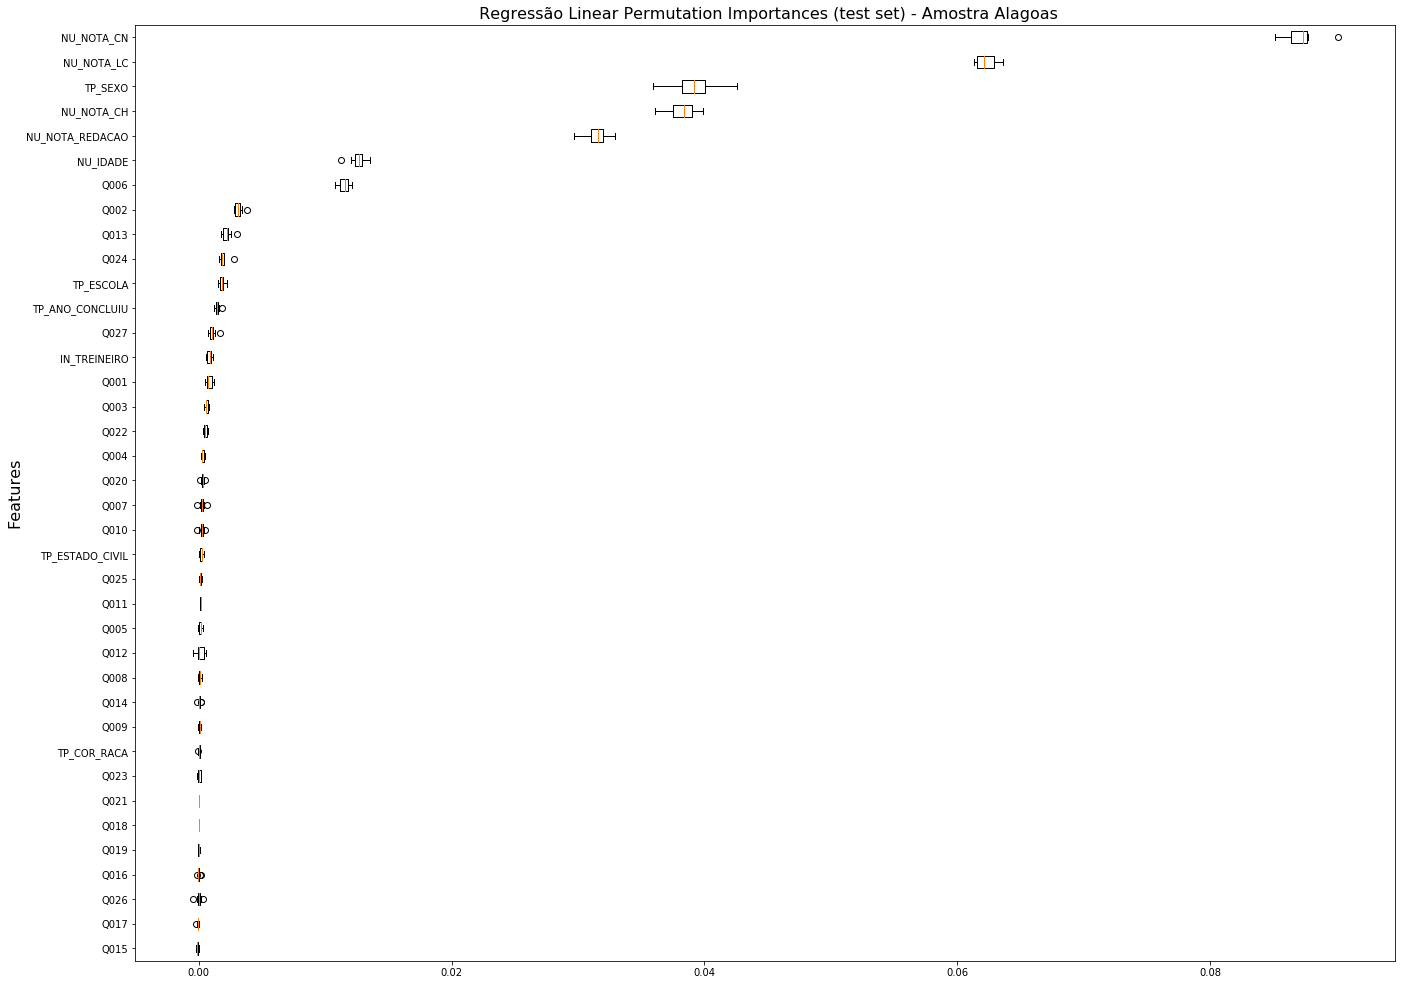

In [15]:
result = permutation_importance(lr, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title(" Regressão Linear Permutation Importances (test set) - Amostra Alagoas", fontsize=16)
ax.set_ylabel("Features", fontsize = 16)
fig.tight_layout(pad=1.08, h_pad=5, w_pad=5, rect=None)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.savefig('imagens/permutationImportances_LR_MT_AL.png', format='png')

plt.show()

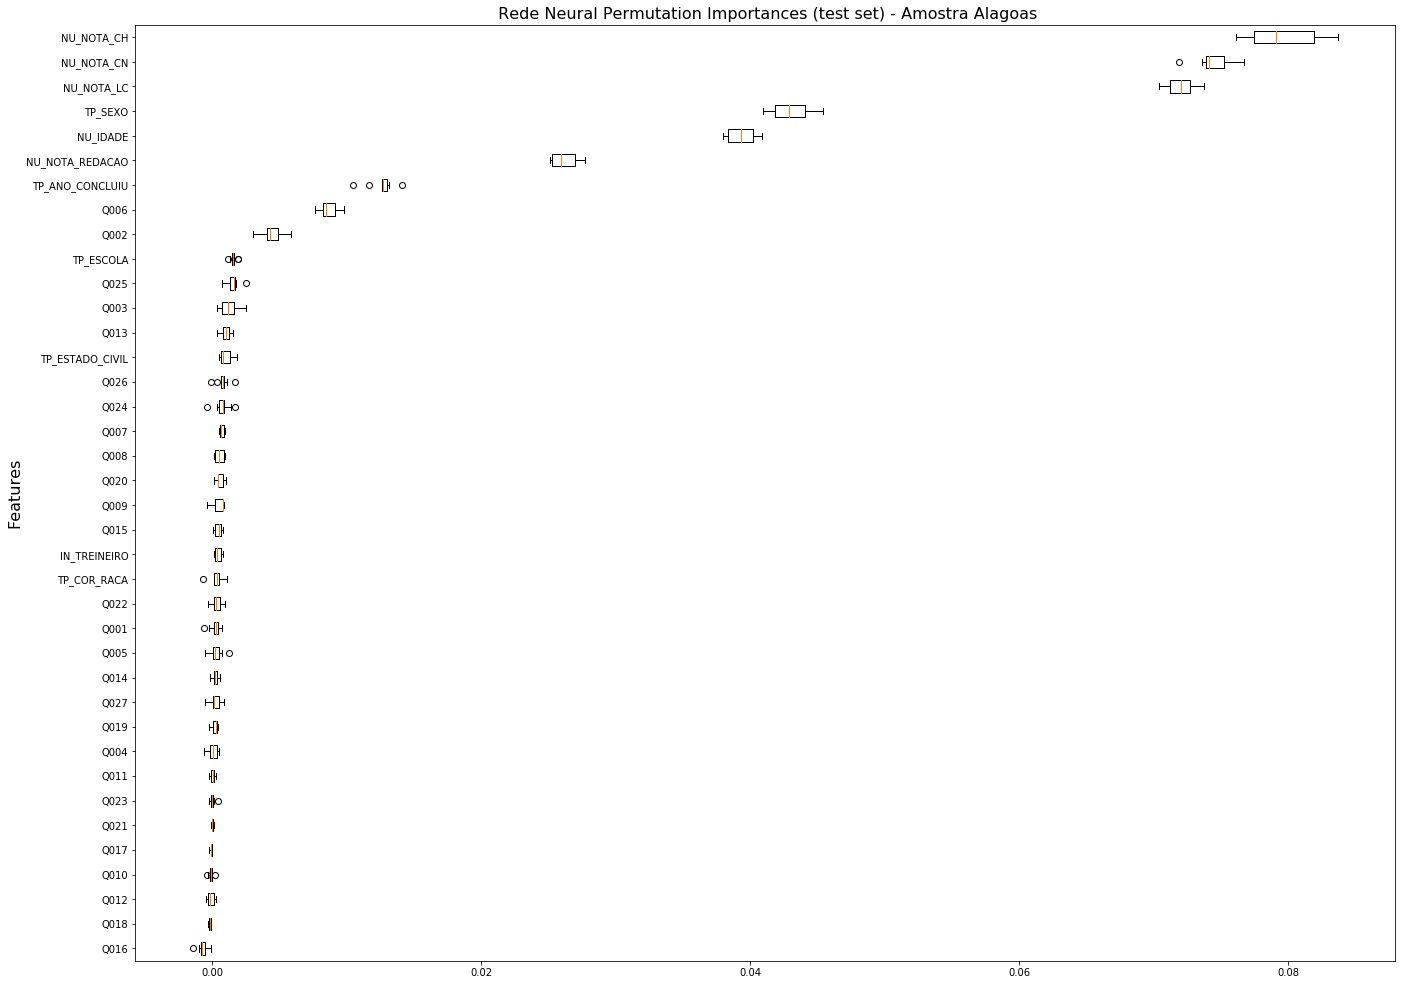

In [16]:
result = permutation_importance(rn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title(" Rede Neural Permutation Importances (test set) - Amostra Alagoas", fontsize=16)
ax.set_ylabel("Features", fontsize = 16)
fig.tight_layout(pad=1.08, h_pad=5, w_pad=5, rect=None)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.savefig('imagens/permutationImportances_RN_MT_AL.png', format='png')

plt.show()

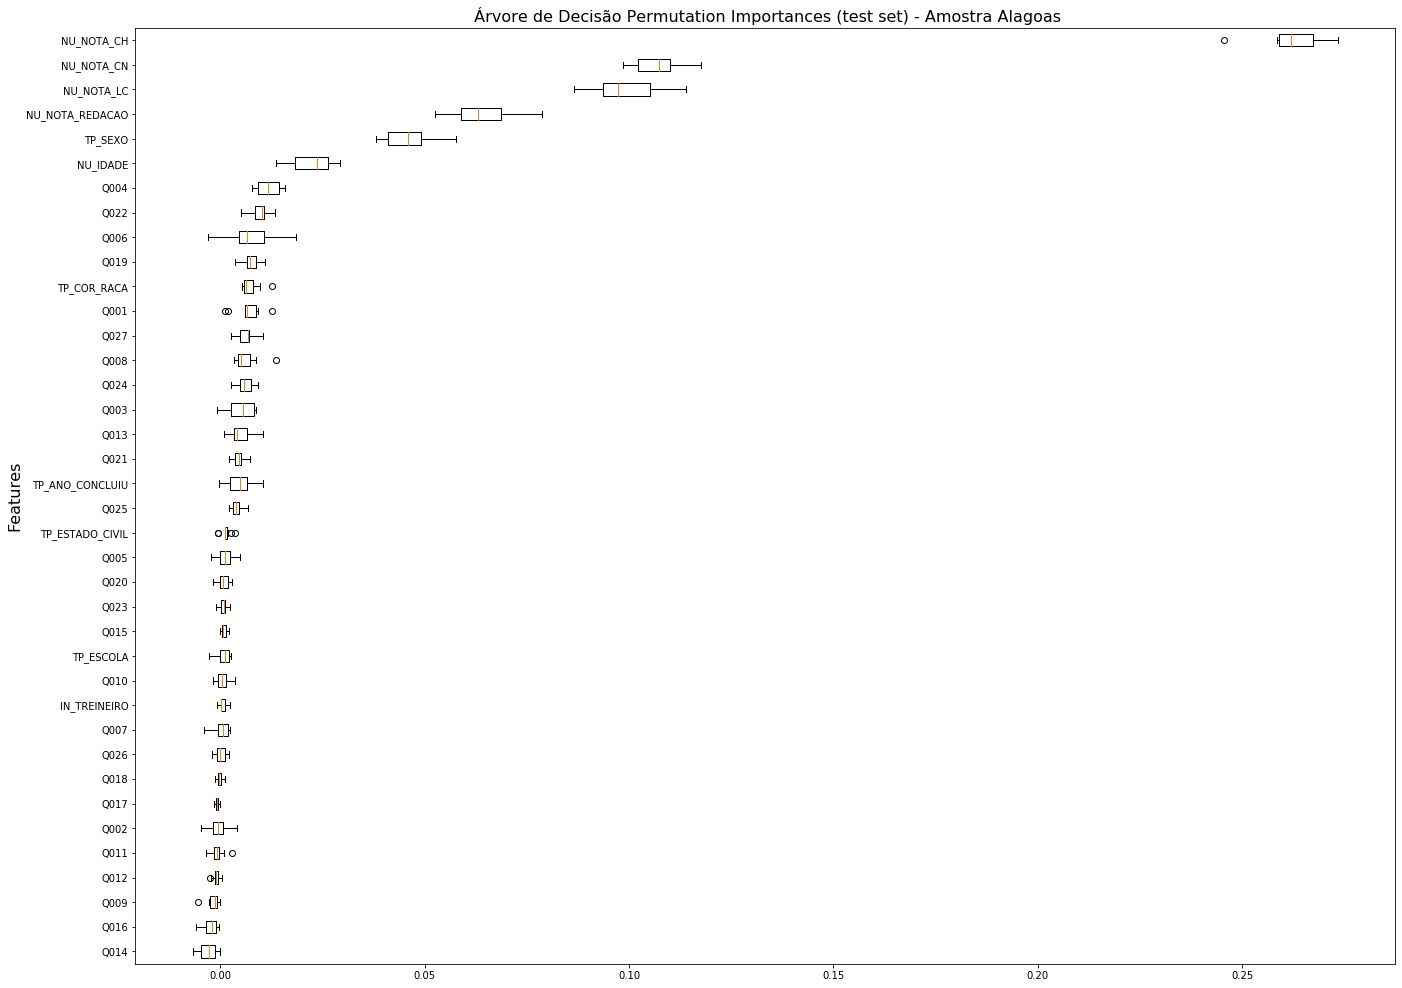

In [17]:
result = permutation_importance(dtree, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(20, 20))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title(" Árvore de Decisão Permutation Importances (test set) - Amostra Alagoas", fontsize=16)
ax.set_ylabel("Features", fontsize = 16)
fig.tight_layout(pad=1.08, h_pad=5, w_pad=5, rect=None)
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
plt.savefig('imagens/permutationImportances_DT_MT_AL.png', format='png')

plt.show()